# اصلی

In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import segmentation_models as sm
# تنظیم فریم‌ورک (مخصوص TensorFlow)
sm.set_framework('tf.keras')
sm.framework()

from segmentation_models import Unet
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

Segmentation Models: using `keras` framework.


In [2]:
# تعریف dice metric و loss
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_metric(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

In [3]:
# تنظیمات
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# تنظیم پارامترها
IMG_SIZE = 128
DATA_DIR = 'C:/Users/Shahab/Downloads/Jupyter/Brain-Tumor/Create-Model-Brain-Tumor-Segmentation/Dataset/'
image_dir = os.path.join(DATA_DIR, 'images')
mask_dir = os.path.join(DATA_DIR, 'masks')

In [4]:
# خواندن تصاویر و ماسک‌ها
images = []
masks = []

for fname in os.listdir(image_dir):
    img = cv2.imread(os.path.join(image_dir, fname), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = np.stack([img]*3, axis=-1)  # تبدیل به 3 کاناله برای ResNet
    images.append(img)

    mask = cv2.imread(os.path.join(mask_dir, fname), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 0).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)  # (H, W, 1)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)

# نرمال‌سازی ورودی‌ها برای backbone
images = preprocess_input(images)

In [5]:
# تقسیم داده‌ها
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# ساخت مدل U-Net با backbone آماده
model = Unet(BACKBONE, classes=1, activation='sigmoid', encoder_weights='imagenet')

# کامپایل مدل
model.compile(optimizer=Adam(learning_rate=0.001), loss=bce_dice_loss, metrics=['accuracy', dice_metric])

In [6]:
# آموزش مدل
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
118/118 [==============================] - 860s 7s/step - loss: 0.7319 - accuracy: 0.9634 - dice_metric: 0.4140 - val_loss: 0.7894 - val_accuracy: 0.9815 - val_dice_metric: 0.2978
Epoch 2/20
118/118 [==============================] - 938s 8s/step - loss: 0.2748 - accuracy: 0.9901 - dice_metric: 0.7651 - val_loss: 1.1554 - val_accuracy: 0.9622 - val_dice_metric: 0.3406
Epoch 3/20
118/118 [==============================] - 940s 8s/step - loss: 0.2164 - accuracy: 0.9920 - dice_metric: 0.8164 - val_loss: 0.2461 - val_accuracy: 0.9918 - val_dice_metric: 0.7897
Epoch 4/20
118/118 [==============================] - 1081s 9s/step - loss: 0.1908 - accuracy: 0.9929 - dice_metric: 0.8383 - val_loss: 0.2294 - val_accuracy: 0.9919 - val_dice_metric: 0.8053
Epoch 5/20
118/118 [==============================] - 983s 8s/step - loss: 0.1681 - accuracy: 0.9937 - dice_metric: 0.8574 - val_loss: 0.2309 - val_accuracy: 0.9911 - val_dice_metric: 0.8058
Epoch 6/20
118/118 [========================

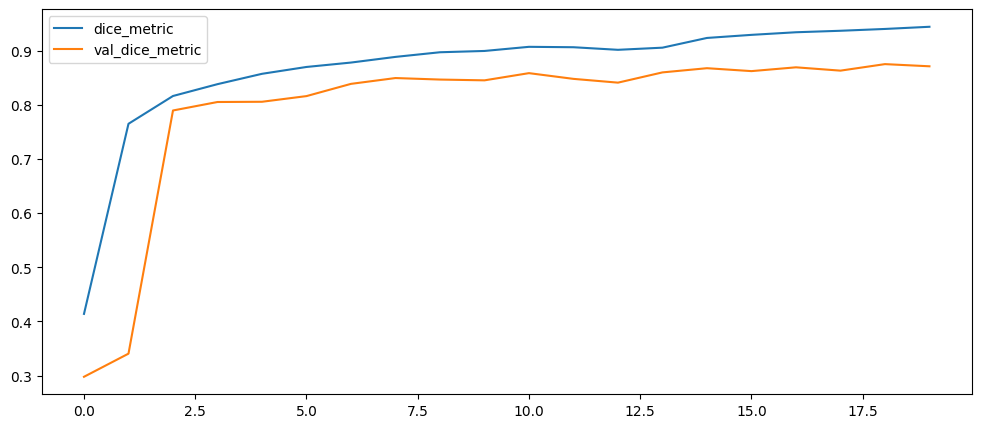

In [7]:
fig , ax = plt.subplots(figsize=(12,5))
ax.plot(history.history['dice_metric'], label = 'dice_metric')
ax.plot(history.history['val_dice_metric'], label = 'val_dice_metric')
ax.legend()

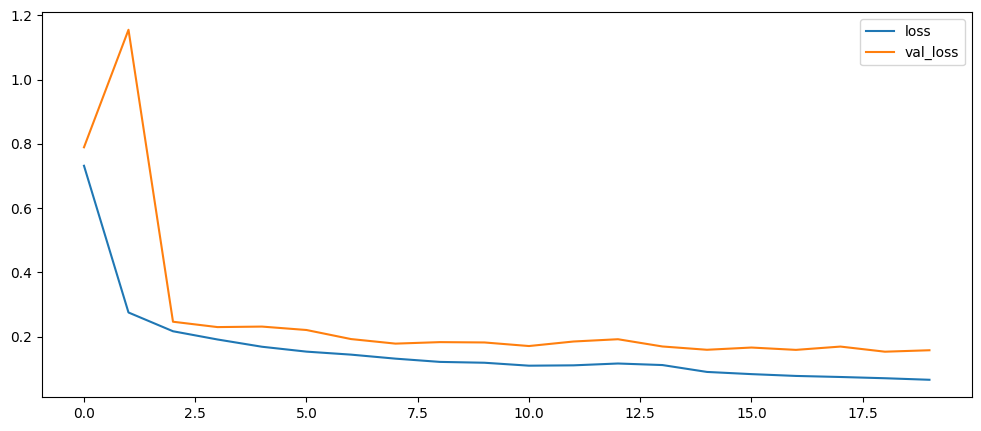

In [8]:
fig , ax = plt.subplots(figsize=(12,5))
ax.plot(history.history['loss'], label = 'loss')
ax.plot(history.history['val_loss'], label = 'val_loss')
ax.legend()

In [9]:
model.save('tumor_segmentation_model2.h5')

In [10]:
from tensorflow.keras.models import load_model
model = load_model('tumor_segmentation_model2.h5', compile=False)

In [20]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# بارگذاری مدل ذخیره‌شده
#model = load_model('unet_brain_mri_segmentation.h5')

# مسیر تصویر MRI تست
img_path = 'm (39).jpg'
mask_path = 'TCGA_DU_5871_19941206_25_mask.tif'

img_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#img = cv2.imread(img_path)
img = cv2.resize(img, (128, 128))
img = np.stack([img]*3, axis=-1)
img = preprocess_input(img)
#input_img = img / 255.0
#input_img = np.expand_dims(input_img, axis=(0, -1))  # (1, 128, 128, 1)
input_img = np.expand_dims(img, axis=(0))
# پیش‌بینی ماسک
pred_mask = model.predict(input_img)#[0, :, :, 0]
binary_mask = (pred_mask > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 121ms/step


In [21]:
# بازگردانی تصویر اصلی برای نمایش
orig_img = cv2.imread(img_path)
orig_img = cv2.resize(orig_img, (128, 128))

# پیدا کردن کانتور در ماسک باینری
contours, _ = cv2.findContours(binary_mask[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # گرفتن بزرگ‌ترین کانتور
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)

    # کشیدن مستطیل روی تصویر اصلی
    boxed = orig_img.copy()
    cv2.rectangle(boxed, (x, y), (x + w, y + h), (0, 255, 0), 1)
    cv2.putText(boxed, "Tumor", (x, y - 3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

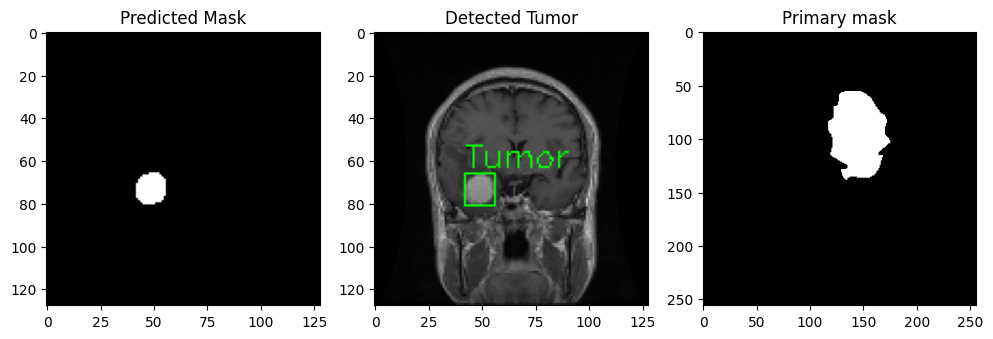

In [22]:
fig , ax = plt.subplots(1,3, figsize=(12,8))
ax[0].set_title('Predicted Mask')
ax[0].imshow(binary_mask[0], cmap='gray')

ax[1].set_title('Detected Tumor')
ax[1].imshow(cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB))

ax[2].set_title('Primary mask')
ax[2].imshow(img_mask, cmap='gray')

In [7]:
#model.save('tumor_segmentation_model.h5')

# عکس سه بعدی برای بررسی تومور

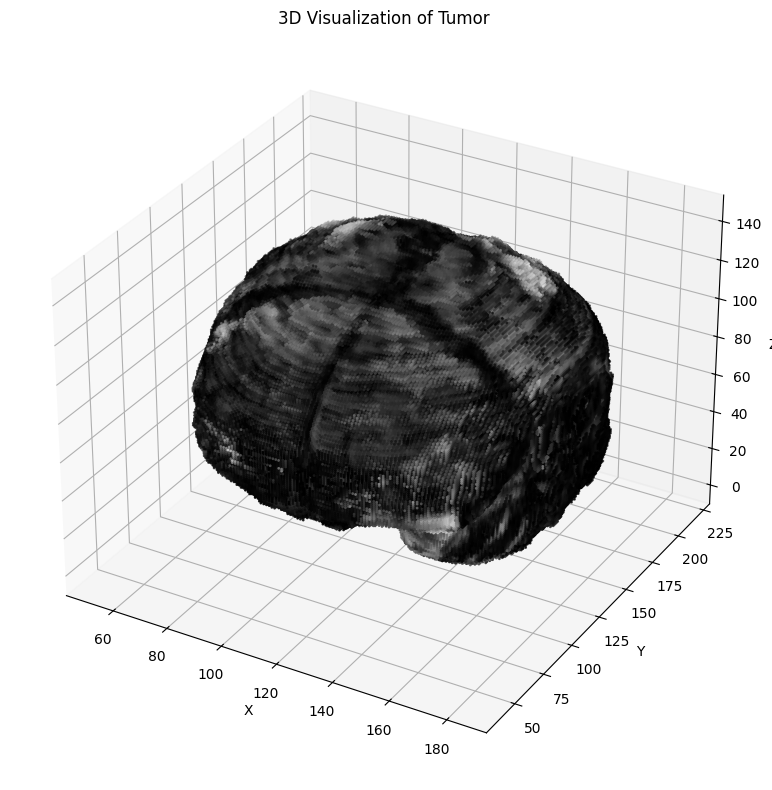

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# فرض: این متغیر ماسک سه‌بعدی شماست که تومور را مشخص می‌کند (باید مقدار 0 یا 1 داشته باشد)
# اگر آماده داری، جایگزین کن. اگر نه، برای تست می‌سازیمش:
# mask_volume = np.load('your_mask.npy')  ← ماسک آماده
import nibabel as nib
img = nib.load('C:/Users/Shahab/Downloads/Jupyter/Brain-Tumor/Dataset/segmentation/Data2/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_310/BraTS20_Training_310_flair.nii')
volume = img.get_fdata()

# مختصات نقاطی که مقدارشان 1 است (یعنی تومور)
threshold = 70
x, y, z = np.where(volume > threshold)
intensities = volume[x, y, z]

# رسم
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=intensities, s=1, cmap='gray')
ax.set_title("3D Visualization of Tumor")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()

In [11]:
x

array([ 52,  52,  52, ..., 184, 184, 184], dtype=int64)

In [12]:
np.where(volume > threshold)

(array([ 52,  52,  52, ..., 184, 184, 184], dtype=int64),
 array([134, 135, 136, ..., 150, 151, 151], dtype=int64),
 array([54, 55, 55, ..., 66, 65, 66], dtype=int64))